In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import seaborn as sns
from collections import defaultdict, Counter
import re
from matplotlib.font_manager import FontProperties

In [2]:
switch_router = {'s1':'r1 r2', 's2':'r2 r3', 's3':'r3 r4', 's4':'r4 r5', 's5':'r5 r6', 's6':'r6 r1', 's7':'ri1 ri2',
                's8':'ri2 ri3', 's9':'ri3 ri4', 's10':'ri4 ri1', 's11':'r1 ri2', 's12':'r3 ri2', 's13':'r3 ri3',
                's14':'r4 ri4', 's15':'r6 ri4', 's16':'r6 ri1'}
FILES_DIR = './'

In [3]:
dir_content = os.listdir(FILES_DIR)
predictions = sorted([f for f in dir_content if 'loss_' in f])
mininet_dumps = sorted([f for f in dir_content if 'mininet_dump_' in f])

In [4]:
def get_path(line):
    path = line.split(':')[1]
    path = re.sub('[\'\[\],]','', path)#.split()
    return path

# string with the mininet dump containing the loss of each interface on the switches
def get_link_w_loss(mn_loss):
    link = []
    step = 7
    idx = np.arange(0,len(mn_loss.split()), step)
    losses = [mn_loss.split()[i:i+step] for i in idx]
    for l in losses:
        if l[2]!= '0%':
            link.append(switch_router[l[0]])
    return link

# check if a path include a link with loss
# return the number of traversed link with loss and total number of links
def cnt_loss(path, link_loss):
    #print(path, link_loss)
    path = path.split()
    cnt = 0
    for i in range(len(path)-1):
        l = path[i] + ' ' + path[i+1]
        l2 = path[i+1] + ' ' + path[i]
        if l in link_loss or l2 in link_loss:
            cnt+=1
    #print('Path {:} - Traversed {:} link with loss'.format(path,cnt))
    return cnt, len(path)-1


# computes for all the targets in a run the total number of link with loss used
def path_stats(counter, link_loss):
    total = 0
    paths_length = 0
    for t, cnt in counter.items():
        #print(cnt)
        for c in cnt:
            # counting the total number of times the link has been used
            loss, length = cnt_loss(c, link_loss)
            paths_length +=length* cnt[c]
            #print(c, loss,cnt[c])
            total+=loss * cnt[c]
    #print(total)
    return total, paths_length
    
def path_counter(dic):
    cnt = {}
    for k, i in dic.items():
        cnt[k]=Counter(i)
    return cnt

def iteration_stats(ospf_paths, pred_paths, link_loss):
    ospf_cnt = path_counter(ospf_paths)
    pred_cnt = path_counter(pred_paths)
    lnk = get_link_w_loss(link_loss)
    pred_stats, pred_tot_length = path_stats(pred_cnt, lnk)
    ospf_stats, ospf_tot_length = path_stats(ospf_cnt, lnk)
    print('Link with loss traversed:\nOSPF:{:}/{:} LSTM:{:}/{:}'.format(ospf_stats, ospf_tot_length, pred_stats, pred_tot_length))
    print('-'*30)
    return ospf_stats, ospf_tot_length, pred_stats, pred_tot_length

In [5]:
for pr, mn in zip(predictions, mininet_dumps):
    ospf = defaultdict(list)
    pred = defaultdict(list)
    link_loss='********'
    ospf_loss = 0
    ospf_tot_l = 0
    pred_loss = 0
    pred_tot_l = 0
    print(pr)
    print()
    with open(os.path.join(FILES_DIR, pr), 'r') as pr_f, open(os.path.join(FILES_DIR, mn), 'r') as mn_f:
        for i,line in enumerate(pr_f):
            line = line.strip()
            if 'ITERATION' in line:
                # starting new iteration
                if ospf and pred:
                    ospf_it_loss, ospf_it_length, pred_it_loss, pred_it_length = iteration_stats(ospf, pred, link_loss)
                    ospf_loss += ospf_it_loss
                    ospf_tot_l += ospf_it_length
                    pred_loss += pred_it_loss
                    pred_tot_l += pred_it_length
                    
                ospf = defaultdict(list)
                pred = defaultdict(list)
                # getting the link loss
                link_loss = mn_f.readline().strip()
                while '*' in link_loss:
                    link_loss = mn_f.readline().strip()
                
            # matching the target of the prediction
            elif re.match('r(\d+)_(\d+)_(\d+)_(\d+)_(\d+)', line):
                target = line
            
            elif 'prediction' in line:
                pred[target].append(get_path(line))
            
            elif 'ospf' in line:
                ospf[target].append(get_path(line))
            else:
                pass

        ospf_it_loss, ospf_it_length, pred_it_loss, pred_it_length = iteration_stats(ospf, pred, link_loss)
        ospf_loss += ospf_it_loss
        ospf_tot_l += ospf_it_length
        pred_loss += pred_it_loss
        pred_tot_l += pred_it_length
        print('TOTAL link with loss traversed:\nOSPF:{:}/{:} LSTM:{:}/{:}'.format(ospf_loss, ospf_tot_l, pred_loss, pred_tot_l))
        print('*'*30)



loss_05

Link with loss traversed:
OSPF:1200/2800 LSTM:901/2970
------------------------------
Link with loss traversed:
OSPF:800/2800 LSTM:837/2994
------------------------------
Link with loss traversed:
OSPF:1000/2800 LSTM:1090/3025
------------------------------
Link with loss traversed:
OSPF:1600/2800 LSTM:1400/2966
------------------------------
Link with loss traversed:
OSPF:1800/2800 LSTM:1626/3015
------------------------------
Link with loss traversed:
OSPF:1000/2800 LSTM:1210/3035
------------------------------
Link with loss traversed:
OSPF:2000/2800 LSTM:2080/3020
------------------------------
Link with loss traversed:
OSPF:2000/2800 LSTM:1916/2997
------------------------------
Link with loss traversed:
OSPF:2400/2800 LSTM:2430/3020
------------------------------
Link with loss traversed:
OSPF:1800/2800 LSTM:1896/3082
------------------------------
TOTAL link with loss traversed:
OSPF:15600/28000 LSTM:15386/30124
******************************
loss_10

Link with loss tra

In [6]:
ospf_links = [15600, 13000, 13000]
lstm_links = [15386, 13437, 13007]
x1 = [0.9,1.9,2.9]
x2 = [1.1, 2.1, 3.1]

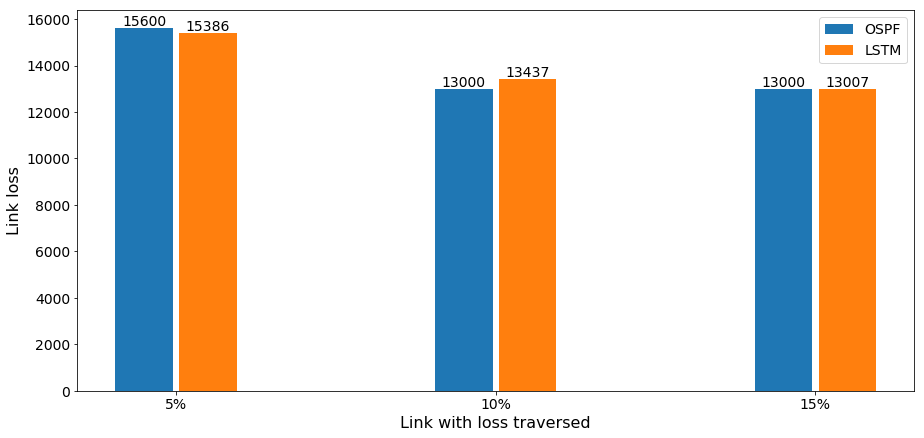

In [7]:
font=FontProperties(size=14)
plt.figure(figsize=(15,7))
plt.bar(x1, ospf_links, width=0.18, label='OSPF')
ax = plt.gca()
for i,x in enumerate(x1):
    ax.text(x, ospf_links[i]+100, str(ospf_links[i]), horizontalalignment='center', fontproperties=font)
    
plt.bar(x2, lstm_links, width=0.18, label='LSTM')
for i,x in enumerate(x2):
    ax.text(x, lstm_links[i]+100, str(lstm_links[i]), horizontalalignment='center', fontproperties=font)

plt.yticks(fontsize=14)
plt.ylabel('Link loss', fontsize=16)
plt.xticks([1,2,3], ['5%', '10%', '15%'], fontsize=14)
plt.xlabel('Link with loss traversed', fontsize=16)
plt.legend(fontsize=14)
plt.savefig('stress_test.eps', transparent=True, format='eps', dpi=500,bbox_inches='tight')
plt.show()